2025-12-24 01:25:05.982451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2025-12-24 01:25:05.982474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-24 01:25:07.353288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-12-24 01:25:07.353575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-12-24 01:25:07.353828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could

A=
 [[0 1 0 1]
 [1 0 0 1]
 [0 0 0 1]
 [1 1 1 0]]
P= 2.0
J=
 [[ 0. -0. -1. -0.]
 [-0.  0. -1. -0.]
 [-1. -1.  0. -0.]
 [-0. -0. -0.  0.]]
h=
 [-0.  -0.   0.5 -0.5]
accept_rate: 0.5400000214576721
last x: 1101  |x|= 3  violations(non-edges)= 0  clique_feasible: True


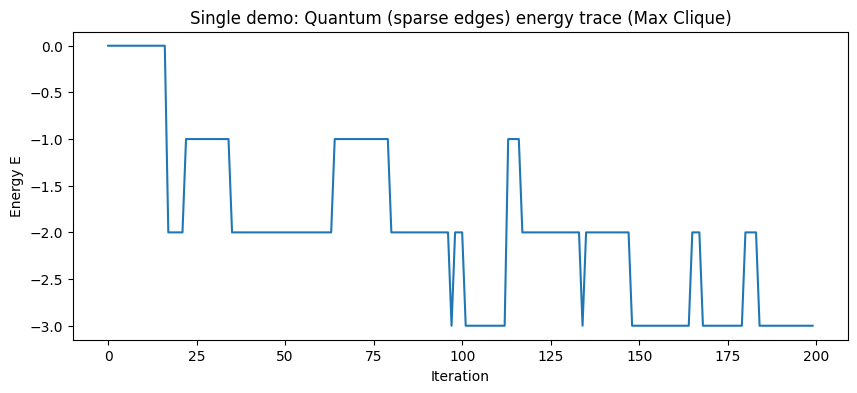

[classical] rep=0/50
[classical] rep=10/50
[classical] rep=20/50
[classical] rep=30/50
[classical] rep=40/50
[quantum] rep=0/50
[quantum] rep=10/50
[quantum] rep=20/50
[quantum] rep=30/50
[quantum] rep=40/50
[local] rep=0/50
[local] rep=10/50
[local] rep=20/50
[local] rep=30/50
[local] rep=40/50

Mean accept rates: classical= 0.12959999918937684 quantum= 0.42331999897956846 local= 0.08050000011920928

[classical] most common last solutions:
  x=1101  count=38/50  |x|=3  feasible=True  violations=0
  x=1100  count=5/50  |x|=2  feasible=True  violations=0
  x=0011  count=4/50  |x|=2  feasible=True  violations=0
  x=0010  count=1/50  |x|=1  feasible=True  violations=0
  x=0101  count=1/50  |x|=2  feasible=True  violations=0

[quantum] most common last solutions:
  x=1101  count=38/50  |x|=3  feasible=True  violations=0
  x=1100  count=6/50  |x|=2  feasible=True  violations=0
  x=0011  count=3/50  |x|=2  feasible=True  violations=0
  x=0010  count=2/50  |x|=1  feasible=True  violations=0
 

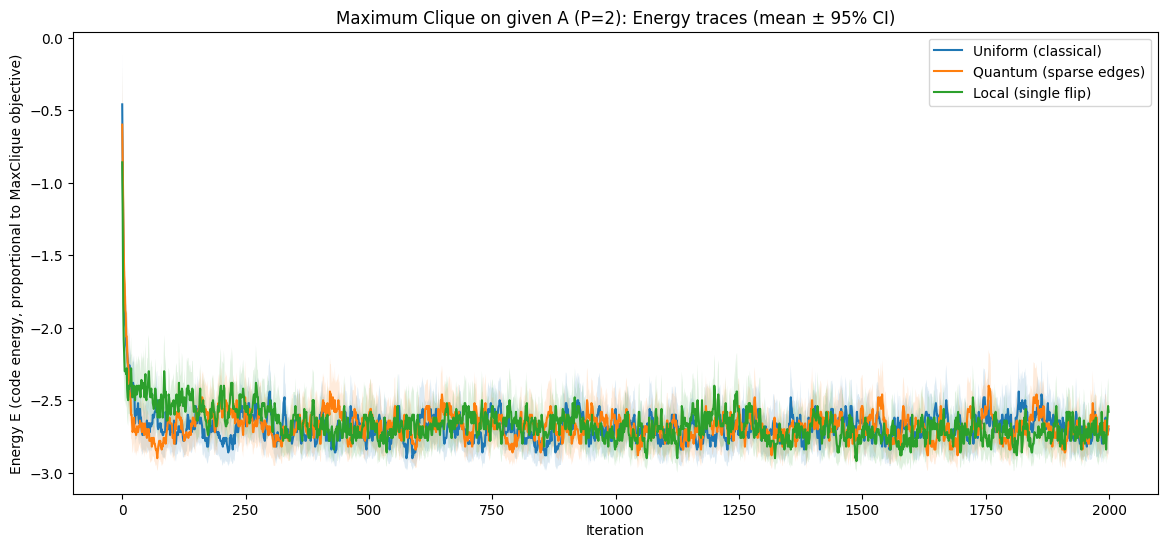

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from qmcmc import IsingMH  


# --------- Maximum Clique: A,P -> (J,h) for your code convention ---------
def maxclique_A_to_Jh_for_code(A, P=2.0, dtype=np.float32):
    """
    Build (J,h) for Maximum Clique (MC) under your code convention:
      logp(s) ∝ (0.5*s^T J s + h^T s)/T
      E_code(s) = -0.5*s^T J s - h^T s  (up to const)

    Maximum Clique as QUBO with penalty on NON-EDGES:
      maximize  sum_i x_i
      subject to: if (i,j) is NOT an edge (A_ij = 0, i!=j) then x_i x_j = 0

    Use penalty formulation:
      minimize  -sum_i x_i + P * sum_{i<j, A_ij=0} x_i x_j

    Mapping:
      x_i = (1 - s_i)/2,  s_i in {-1,+1}

    Notes:
      - A is adjacency of the ORIGINAL graph (edges are 1).
      - We build M = complement adjacency (non-edges) excluding diagonal.
      - Larger P enforces clique constraint more strongly.
    """
    A = np.array(A, dtype=dtype)
    n = A.shape[0]
    assert A.shape == (n, n), "A must be square"

    # M_ij = 1 if i!=j and A_ij == 0 (non-edge), else 0
    M = (1.0 - A).astype(dtype)
    np.fill_diagonal(M, 0.0)

    d = M.sum(axis=1)

    # Standard penalty-Ising (ignoring const) for:
    #   min -sum x_i + P * sum_{i<j} M_ij x_i x_j
    J_std = (P / 4.0) * M
    h_std = 0.5 - (P / 4.0) * d

    # Convert to your code params:
    J_code = -2.0 * J_std
    np.fill_diagonal(J_code, 0.0)
    h_code = -h_std
    return J_code.astype(dtype), h_code.astype(dtype)


# --------- Convert spin s (+1/-1) to binary x (0/1) ---------
def spin_to_x(spin):
    """
    spin: shape (n,) with values in {-1,+1}
    x = (1 - s)/2 in {0,1}
    """
    spin = np.asarray(spin).astype(np.float32)
    x = (1.0 - spin) / 2.0
    return x.astype(np.int32)


def x_to_bitstring(x):
    return "".join(str(int(v)) for v in x)


# --------- Feasibility check: is x a clique in graph A? ---------
def is_clique(A, x):
    """
    x is a clique iff for any selected i<j, A_ij == 1.
    """
    A = np.asarray(A)
    x = np.asarray(x).astype(np.int32)
    idx = np.where(x == 1)[0]
    for a in range(len(idx)):
        for b in range(a + 1, len(idx)):
            i, j = idx[a], idx[b]
            if A[i, j] != 1:
                return False
    return True


def clique_violations(A, x):
    """
    Count number of violating non-edges among selected vertices.
    0 means clique-feasible.
    """
    A = np.asarray(A)
    x = np.asarray(x).astype(np.int32)
    idx = np.where(x == 1)[0]
    v = 0
    for a in range(len(idx)):
        for b in range(a + 1, len(idx)):
            i, j = idx[a], idx[b]
            if A[i, j] == 0:
                v += 1
    return v


# --------- Energy trace extraction ---------
def energy_trace_from_results(results, temperature, true_energy=True):
    """
    results 是 run_mcmc trace_fn 返回的 accepted_results（RWResult）
    results[0] == target_log_prob trajectory
    target_log_prob = (-E)/T
    """
    tlp = results[0]
    tlp = np.squeeze(np.array(tlp))
    if true_energy:
        return -tlp * temperature
    else:
        return -tlp


def run_block_clique(A, P, r, temp, reps, num_steps, kernel_type):
    """
    Repeat reps times:
      - build J,h from A,P (Maximum Clique)
      - run MCMC
      - collect energy trace + last solution bitstring
    """
    A = np.asarray(A, dtype=np.int32)
    n = A.shape[0]
    J, h = maxclique_A_to_Jh_for_code(A, P=P)

    traces = []
    accs = []
    last_bitstrings = []
    last_sizes = []
    last_feasible = []
    last_viol = []

    for rep in range(reps):
        if rep % max(1, reps // 5) == 0:
            print(f"[{kernel_type}] rep={rep}/{reps}")

        mh = IsingMH(n, J, h, r, temp, kernel_type)
        samples, _, _, acc, results = mh.run_mcmc(num_steps, 0)

        E = energy_trace_from_results(results, temp, true_energy=True)
        traces.append(E)
        accs.append(float(acc.numpy()))

        # last state -> x bitstring
        last_spin = np.squeeze(np.array(samples[-1]))  # (n,) in {-1,+1}
        x = spin_to_x(last_spin)
        last_bitstrings.append(x_to_bitstring(x))
        last_sizes.append(int(x.sum()))
        last_feasible.append(bool(is_clique(A, x)))
        last_viol.append(int(clique_violations(A, x)))

    return (
        np.array(traces),
        np.array(accs),
        last_bitstrings,
        np.array(last_sizes),
        np.array(last_feasible),
        np.array(last_viol),
    )


def plot_traces_three(cs, qs, ls, title):
    x = np.arange(cs.shape[1])

    cs_mean = cs.mean(axis=0)
    qs_mean = qs.mean(axis=0)
    ls_mean = ls.mean(axis=0)

    cs_ci = 1.96 * cs.std(axis=0) / np.sqrt(cs.shape[0])
    qs_ci = 1.96 * qs.std(axis=0) / np.sqrt(qs.shape[0])
    ls_ci = 1.96 * ls.std(axis=0) / np.sqrt(ls.shape[0])

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(x, cs_mean, label="Uniform (classical)")
    ax.plot(x, qs_mean, label="Quantum (sparse edges)")
    ax.plot(x, ls_mean, label="Local (single flip)")

    ax.fill_between(x, cs_mean - cs_ci, cs_mean + cs_ci, alpha=0.15)
    ax.fill_between(x, qs_mean - qs_ci, qs_mean + qs_ci, alpha=0.15)
    ax.fill_between(x, ls_mean - ls_ci, ls_mean + ls_ci, alpha=0.15)

    ax.set_title(title)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Energy E (code energy, proportional to MaxClique objective)")
    ax.legend()
    plt.show()


# ----------------- Single demo -----------------
def single_demo_clique(A, P=2.0):
    A = np.asarray(A, dtype=np.int32)
    n = A.shape[0]

    r = 3
    temp = 0.5
    num_steps = 200

    J, h = maxclique_A_to_Jh_for_code(A, P=P)
    print("A=\n", A)
    print("P=", P)
    print("J=\n", J)
    print("h=\n", h)

    mh_q = IsingMH(n, J, h, r, temp, "quantum")
    samples, _, _, acc, results = mh_q.run_mcmc(num_steps, 0)

    E = energy_trace_from_results(results, temp, true_energy=True)
    last_spin = np.squeeze(np.array(samples[-1]))
    x = spin_to_x(last_spin)

    print("accept_rate:", float(acc.numpy()))
    print(
        "last x:", x_to_bitstring(x),
        " |x|=", int(x.sum()),
        " violations(non-edges)=", clique_violations(A, x),
        " clique_feasible:", is_clique(A, x),
    )

    plt.figure(figsize=(10, 4))
    plt.plot(E)
    plt.title("Single demo: Quantum (sparse edges) energy trace (Max Clique)")
    plt.xlabel("Iteration")
    plt.ylabel("Energy E")
    plt.show()


if __name__ == "__main__":
    A = [
        [0, 1, 0, 1],
        [1, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 1, 1, 0],
    ]
    P = 2.0


    single_demo_clique(A, P=P)


    r = 5
    temp = 0.5
    reps = 50
    num_steps = 2000

    cs, ac, c_bits, c_sizes, c_ok, c_viol = run_block_clique(A, P, r, temp, reps, num_steps, "classical")
    qs, aq, q_bits, q_sizes, q_ok, q_viol = run_block_clique(A, P, r, temp, reps, num_steps, "quantum")
    ls, al, l_bits, l_sizes, l_ok, l_viol = run_block_clique(A, P, r, temp, reps, num_steps, "local")

    print("\nMean accept rates:",
          "classical=", ac.mean(),
          "quantum=", aq.mean(),
          "local=", al.mean())


    def summarize_last(bits, sizes, ok, viol, name):
        from collections import Counter
        cnt = Counter(bits)
        top = cnt.most_common(5)
        print(f"\n[{name}] most common last solutions:")
        for b, k in top:
            idx = bits.index(b)
            print(
                f"  x={b}  count={k}/{len(bits)}"
                f"  |x|={sizes[idx]}  feasible={ok[idx]}  violations={viol[idx]}"
            )

    summarize_last(c_bits, c_sizes, c_ok, c_viol, "classical")
    summarize_last(q_bits, q_sizes, q_ok, q_viol, "quantum")
    summarize_last(l_bits, l_sizes, l_ok, l_viol, "local")

    plot_traces_three(cs, qs, ls, "Maximum Clique on given A (P=2): Energy traces (mean ± 95% CI)")

2025-12-24 03:38:23.650322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2025-12-24 03:38:23.650343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-24 03:38:25.021260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-12-24 03:38:25.021576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-12-24 03:38:25.021856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could


3-regular MaxClique demo: n=6, k=3, P=2.0, temp=0.5, r=5, reps=50, steps=2000
n=6 rep=0/50
n=6 rep=10/50
n=6 rep=20/50
n=6 rep=30/50
n=6 rep=40/50

Mean accept rates: classical= 0.06919000070542097 quantum= 0.40506000101566314 local= 0.03097999977180734

[classical] most common last solutions (top 5):
  x=110010  count=5/50  |x|=3  feasible=True  violations=0
  x=100110  count=3/50  |x|=3  feasible=True  violations=0
  x=101010  count=3/50  |x|=3  feasible=True  violations=0
  x=001011  count=3/50  |x|=3  feasible=True  violations=0
  x=010110  count=3/50  |x|=3  feasible=True  violations=0
[classical] mean |x|=2.820, feasible_rate=1.000, mean_viol=0.000

[quantum] most common last solutions (top 5):
  x=100110  count=5/50  |x|=3  feasible=True  violations=0
  x=110010  count=4/50  |x|=3  feasible=True  violations=0
  x=000111  count=3/50  |x|=3  feasible=True  violations=0
  x=101010  count=3/50  |x|=3  feasible=True  violations=0
  x=010110  count=3/50  |x|=3  feasible=True  violati

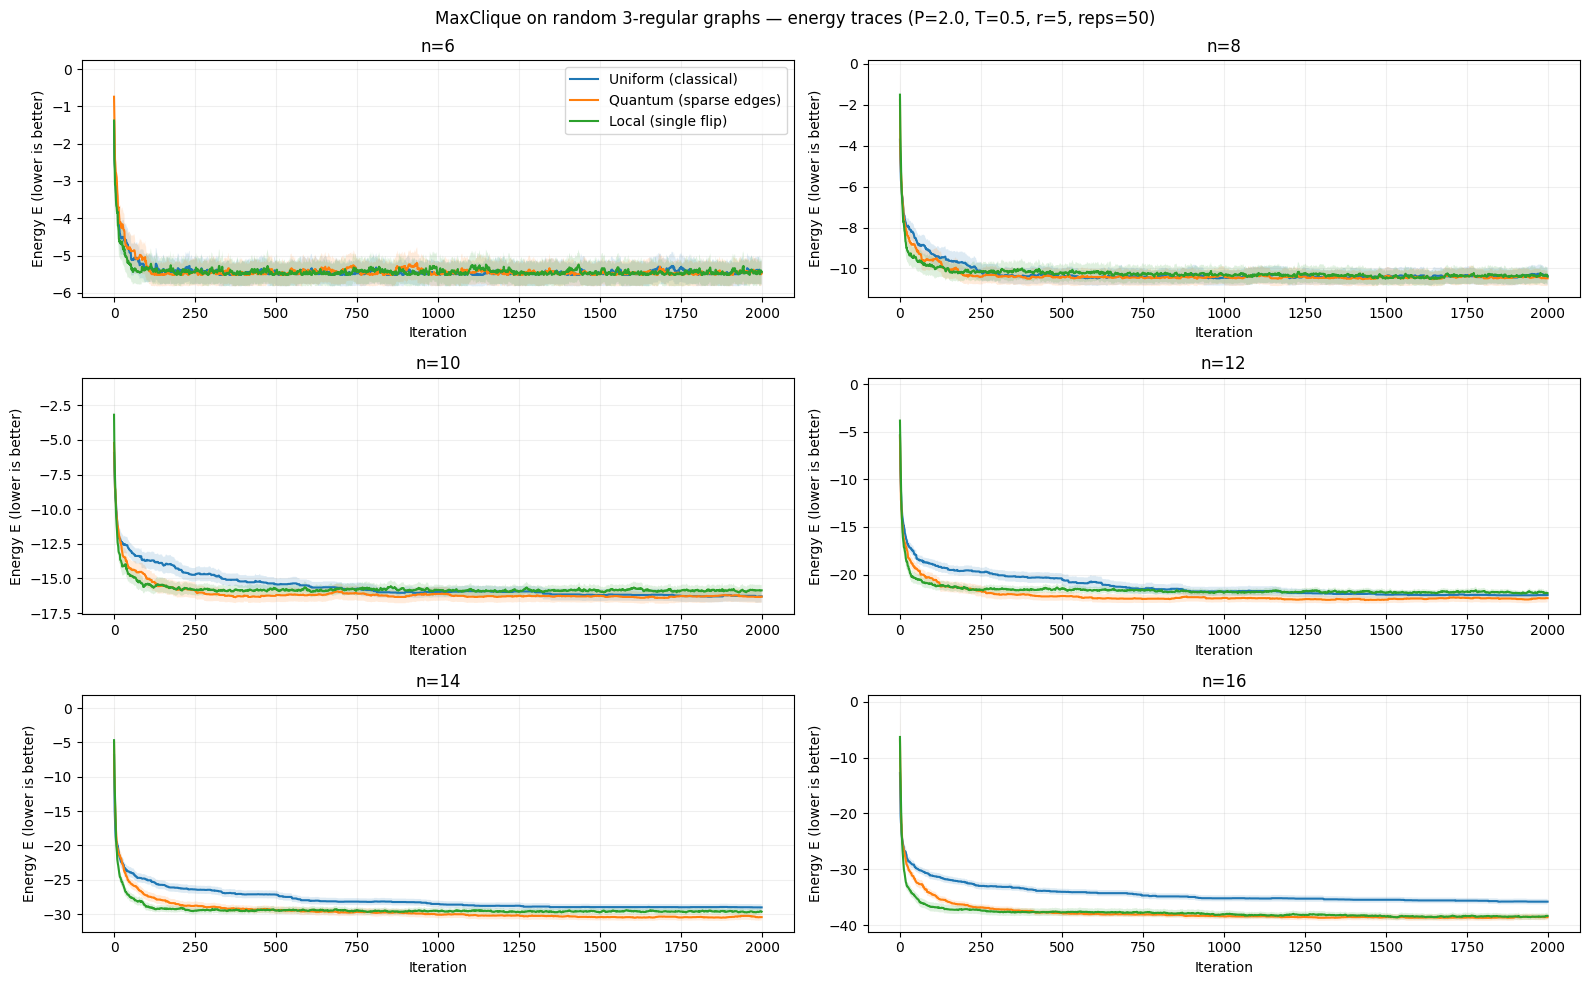

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from qmcmc import IsingMH


# =========================
# 1) 3-regular graph
# =========================
def random_k_regular_simple_adjacency(n, k=3, seed=None, max_tries=2000):
    if (n * k) % 2 != 0:
        raise ValueError(f"Need n*k even, got n={n}, k={k}")
    if n <= k:
        raise ValueError(f"Need n > k for a simple k-regular graph, got n={n}, k={k}")

    rng = np.random.default_rng(seed)

    for _ in range(max_tries):
        stubs = np.repeat(np.arange(n), k)
        rng.shuffle(stubs)

        edges = set()
        ok = True
        for i in range(0, len(stubs), 2):
            u = int(stubs[i])
            v = int(stubs[i + 1])
            if u == v:
                ok = False
                break
            a, b = (u, v) if u < v else (v, u)
            if (a, b) in edges:
                ok = False
                break
            edges.add((a, b))

        if not ok:
            continue

        A = np.zeros((n, n), dtype=np.int32)
        for (u, v) in edges:
            A[u, v] = 1
            A[v, u] = 1

        deg = A.sum(axis=1)
        if np.all(deg == k) and np.all(np.diag(A) == 0):
            return A

    raise RuntimeError(f"Failed to generate simple {k}-regular graph for n={n} after {max_tries} tries.")


# =========================
# 2) MaxClique: A,P -> (J,h) 
# =========================
def maxclique_A_to_Jh_for_code(A, P=2.0, dtype=np.float32):
    A = np.array(A, dtype=dtype)
    n = A.shape[0]
    assert A.shape == (n, n)

    M = (1.0 - A).astype(dtype)
    np.fill_diagonal(M, 0.0)

    d = M.sum(axis=1)

    J_std = (P / 4.0) * M
    h_std = 0.5 - (P / 4.0) * d

    J_code = -2.0 * J_std
    np.fill_diagonal(J_code, 0.0)
    h_code = -h_std
    return J_code.astype(dtype), h_code.astype(dtype)


def spin_to_x(spin):
    spin = np.asarray(spin).astype(np.float32)
    return (((1.0 - spin) / 2.0)).astype(np.int32)


def x_to_bitstring(x):
    return "".join(str(int(v)) for v in x)


def is_clique(A, x):
    A = np.asarray(A)
    x = np.asarray(x).astype(np.int32)
    idx = np.where(x == 1)[0]
    for a in range(len(idx)):
        for b in range(a + 1, len(idx)):
            i, j = idx[a], idx[b]
            if A[i, j] != 1:
                return False
    return True


def clique_violations(A, x):
    A = np.asarray(A)
    x = np.asarray(x).astype(np.int32)
    idx = np.where(x == 1)[0]
    v = 0
    for a in range(len(idx)):
        for b in range(a + 1, len(idx)):
            i, j = idx[a], idx[b]
            if A[i, j] == 0:
                v += 1
    return v


# =========================
# 3) trace -> energy
# =========================
def energy_trace_from_results(results, temperature, true_energy=True):
    tlp = results[0]
    tlp = np.squeeze(np.array(tlp))
    return (-tlp * temperature) if true_energy else (-tlp)


# =========================
# 4) 3 kernels comparison on random k-regular graphs
# =========================
def run_block_maxclique(n, k, P, r, temp, reps, num_steps, seed0=0):
    cs, qs, ls = [], [], []
    acc_c, acc_q, acc_l = [], [], []

    last_c, last_q, last_l = [], [], []
    size_c, size_q, size_l = [], [], []
    ok_c, ok_q, ok_l = [], [], []
    viol_c, viol_q, viol_l = [], [], []

    for rep in range(reps):
        if rep % max(1, reps // 5) == 0:
            print(f"n={n} rep={rep}/{reps}")

        A = random_k_regular_simple_adjacency(n, k=k, seed=seed0 + 10000 * n + rep)
        J, h = maxclique_A_to_Jh_for_code(A, P=P)

        mh_c = IsingMH(n, J, h, r, temp, "classical")
        mh_q = IsingMH(n, J, h, r, temp, "quantum")
        mh_l = IsingMH(n, J, h, r, temp, "local")

        samp_c, _, _, a_c, rs_c = mh_c.run_mcmc(num_steps, 0)
        samp_q, _, _, a_q, rs_q = mh_q.run_mcmc(num_steps, 0)
        samp_l, _, _, a_l, rs_l = mh_l.run_mcmc(num_steps, 0)

        cs.append(energy_trace_from_results(rs_c, temp, True))
        qs.append(energy_trace_from_results(rs_q, temp, True))
        ls.append(energy_trace_from_results(rs_l, temp, True))

        acc_c.append(float(a_c.numpy()))
        acc_q.append(float(a_q.numpy()))
        acc_l.append(float(a_l.numpy()))

        x_c = spin_to_x(np.squeeze(np.array(samp_c[-1])))
        x_q = spin_to_x(np.squeeze(np.array(samp_q[-1])))
        x_l = spin_to_x(np.squeeze(np.array(samp_l[-1])))

        last_c.append(x_to_bitstring(x_c))
        last_q.append(x_to_bitstring(x_q))
        last_l.append(x_to_bitstring(x_l))

        size_c.append(int(x_c.sum()))
        size_q.append(int(x_q.sum()))
        size_l.append(int(x_l.sum()))

        ok_c.append(bool(is_clique(A, x_c)))
        ok_q.append(bool(is_clique(A, x_q)))
        ok_l.append(bool(is_clique(A, x_l)))

        viol_c.append(int(clique_violations(A, x_c)))
        viol_q.append(int(clique_violations(A, x_q)))
        viol_l.append(int(clique_violations(A, x_l)))

    return (
        np.array(cs), np.array(qs), np.array(ls),
        np.array(acc_c), np.array(acc_q), np.array(acc_l),
        last_c, last_q, last_l,
        np.array(size_c), np.array(size_q), np.array(size_l),
        np.array(ok_c), np.array(ok_q), np.array(ok_l),
        np.array(viol_c), np.array(viol_q), np.array(viol_l),
    )


def summarize(bits, sizes, ok, viol, name, topk=5):
    cnt = Counter(bits)
    print(f"\n[{name}] most common last solutions (top {topk}):")
    for b, k in cnt.most_common(topk):
        i = bits.index(b)
        print(f"  x={b}  count={k}/{len(bits)}  |x|={sizes[i]}  feasible={ok[i]}  violations={viol[i]}")
    print(f"[{name}] mean |x|={sizes.mean():.3f}, feasible_rate={ok.mean():.3f}, mean_viol={viol.mean():.3f}")


# =========================
# 5) plotting
# =========================
def plot_traces_ax(ax, cs, qs, ls, title, show_legend=False):
    x = np.arange(cs.shape[1])

    cs_mean, qs_mean, ls_mean = cs.mean(0), qs.mean(0), ls.mean(0)
    cs_ci = 1.96 * cs.std(0) / np.sqrt(cs.shape[0])
    qs_ci = 1.96 * qs.std(0) / np.sqrt(qs.shape[0])
    ls_ci = 1.96 * ls.std(0) / np.sqrt(ls.shape[0])

    ax.plot(x, cs_mean, label="Uniform (classical)")
    ax.plot(x, qs_mean, label="Quantum (sparse edges)")
    ax.plot(x, ls_mean, label="Local (single flip)")
    ax.fill_between(x, cs_mean - cs_ci, cs_mean + cs_ci, alpha=0.15)
    ax.fill_between(x, qs_mean - qs_ci, qs_mean + qs_ci, alpha=0.15)
    ax.fill_between(x, ls_mean - ls_ci, ls_mean + ls_ci, alpha=0.15)

    ax.set_title(title)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Energy E (lower is better)")
    ax.grid(True, alpha=0.2)

    if show_legend:
        ax.legend(loc="best")


def plot_all_ns_in_one_picture(results_by_n, ns, ncols=2, figsize=(16, 10), suptitle=None):
    """
    results_by_n[n] = (cs, qs, ls)
    在一个 figure 里用子图网格画出所有 n 的曲线
    """
    nplots = len(ns)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for idx, n in enumerate(ns):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]
        cs, qs, ls = results_by_n[n]
        plot_traces_ax(ax, cs, qs, ls, title=f"n={n}", show_legend=(idx == 0))


    for idx in range(nplots, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r][c].axis("off")

    if suptitle:
        fig.suptitle(suptitle)

    fig.tight_layout()
    plt.show()


# =========================
# 6) main
# =========================
if __name__ == "__main__":
    k = 3
    P = 2.0

    # MCMC parameters
    r = 5
    temp = 0.5
    reps = 50
    num_steps = 2000

    ns = [6, 8, 10, 12, 14, 16]

    results_by_n = {}

    for n in ns:
        print("\n" + "=" * 80)
        print(f"3-regular MaxClique demo: n={n}, k={k}, P={P}, temp={temp}, r={r}, reps={reps}, steps={num_steps}")
        print("=" * 80)

        (
            cs, qs, ls,
            ac, aq, al,
            c_bits, q_bits, l_bits,
            c_sizes, q_sizes, l_sizes,
            c_ok, q_ok, l_ok,
            c_viol, q_viol, l_viol
        ) = run_block_maxclique(n, k, P, r, temp, reps, num_steps, seed0=123)

        results_by_n[n] = (cs, qs, ls)

        print("\nMean accept rates:",
              "classical=", ac.mean(),
              "quantum=", aq.mean(),
              "local=", al.mean())

        summarize(c_bits, c_sizes, c_ok, c_viol, "classical")
        summarize(q_bits, q_sizes, q_ok, q_viol, "quantum")
        summarize(l_bits, l_sizes, l_ok, l_viol, "local")


    plot_all_ns_in_one_picture(
        results_by_n,
        ns,
        ncols=2,  
        figsize=(16, 10),
        suptitle=f"MaxClique on random {k}-regular graphs — energy traces (P={P}, T={temp}, r={r}, reps={reps})",
    )